# ELO Customer Loyalty - non-spark version

## Downloading data

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c elo-merchant-category-recommendation

In [ ]:
!unzip historical_transactions.csv.zip
!unzip merchants.csv.zip
!unzip new_merchant_transactions.csv.zip
!unzip sample_submission.csv.zip
!unzip test.csv.zip
!unzip train.csv.zip

## Imports

In [ ]:
import gc
import time
from datetime import date, datetime
from functools import reduce
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score, cross_validate, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
from scipy.stats import randint, uniform

## Utilities

In [ ]:
# Taken from https://www.kaggle.com/fabiendaniel/elo-world

def reduce_mem_usage(df, verbose=True):
  '''
    An utility to reduce the memory of pandas dataframes by converting the columns 
    of numeric datatypes to lower sizes without losing any information, 
    based on the range of values in the column.
  '''

  numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
  start_mem = df.memory_usage().sum() / 1024**2    
  for col in df.columns:
      col_type = df[col].dtypes
      if col_type in numerics:
          c_min = df[col].min()
          c_max = df[col].max()
          if str(col_type)[:3] == 'int':
              if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                  df[col] = df[col].astype(np.int8)
              elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                  df[col] = df[col].astype(np.int16)
              elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                  df[col] = df[col].astype(np.int32)
              elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                  df[col] = df[col].astype(np.int64)  
          else:
              if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                  df[col] = df[col].astype(np.float16)
              elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                  df[col] = df[col].astype(np.float32)
              else:
                  df[col] = df[col].astype(np.float64)    
  end_mem = df.memory_usage().sum() / 1024**2
  if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
  return df

In [ ]:
def pandas_random_forest_regr(pdf, excl_cols=['card_id'], target='target', num_of_folds=5, scoring_metric='neg_mean_squared_error', n_jobs=1):
  '''
      Takes in a pandas dataframe pdf and fits a random forest regressor to
      it using K-fold cross-validation.

      It returns the list of cross-validation scores.

      excl_cols: ignore the columns in excl_cols that are in pdf
      target: column in pdf to use a target
              features = pdf.columns - excl_cols - target
      num_of_folds: no of folds to use for K-fold cross-validation
      scoring_metric: metric to use in cross-validation scoring
  '''
  non_feature_cols = excl_cols+[target]
  feature_cols = [col for col in pdf.columns if col not in non_feature_cols]

  X,y = pdf[feature_cols], pdf[target]

  random_forest_regressor = RandomForestRegressor()
  cvfolds = KFold(n_splits=num_of_folds)

  return cross_val_score(estimator=random_forest_regressor,X=X,y=y,cv=cvfolds,scoring=scoring_metric, verbose=3, n_jobs=n_jobs)

In [ ]:
def proportion_feature_generator(df_source, col, df_target, col_name_prefix, key_col = 'card_id'):
  '''
      There are categorical columns in histTxns where we would want to derive
      the proportion of trasactions belonging to each category. This utility
      - takes as input the transaction data containing dataframe df_source,
      - derives the category-wise proportion for the column col in df_source for
        each value of key_col 
      - and merges it with df_target, the dataframe that contains
        the new features.
      The column names of the proportion features are decided from col_name_prefix
      appended with _{value of the category}.
  '''
  
  col_name = lambda val: col_name_prefix + '_' + str(val)

  groupwise_count = df_source.groupby(key_col, sort=False)[col].value_counts(normalize=True, sort=False).unstack(level=-1, fill_value=0.0).\
                    rename(columns=col_name)

  return df_target.merge(groupwise_count, how='left', on=key_col)

In [ ]:
def proportions(g, n, col, group_by, entry_col_name, proportion_col_name):

  dataframes = []

  for i in range(n):
    dataframes.append(g.iloc[i:i+1].reset_index(level=col, name=proportion_col_name+str(i+1)).rename(columns={col:entry_col_name+str(i+1)}))
    # g2 = g.iloc[1:2].reset_index(level='city', name='2Prop').rename(columns={'city':'city2'})
    # g3 = g.iloc[2:3].reset_index(level='city', name='3Prop').rename(columns={'city':'city3'})

  return reduce(lambda  left,right: pd.merge(left,right,on=group_by, how='outer'), dataframes)

def top_n_entries_and_proportion(df, n, col, entry_col_name_prefix, proportion_col_name_prefix, df_target, group_by='card_id'):

  s = df.groupby(group_by, sort=False)[col].value_counts(normalize=True, sort=False).groupby(level=0, group_keys=False, sort=False).nlargest(n=n)
  new_df = s.groupby(level=group_by, group_keys=False, sort=False).apply(proportions, n, col, group_by, entry_col_name_prefix, proportion_col_name_prefix).fillna(0.0)
  return df_target.merge(new_df, how='left', on=group_by)

In [ ]:
def top_n_entries_and_proportion_modified(df, n, col, entry_col_name_prefix, proportion_col_name_prefix, df_target, group_by='card_id'):
    
    value_counts_start_time = time.time()
    dataframes = []
    d_all = df.groupby(group_by, sort=False)[col].value_counts(normalize=True, sort=False).groupby(level=0, group_keys=False, sort=False).nlargest(n).reset_index(level=col, name='prop')
    for i in range(n):
        d = d_all.groupby(level=0, group_keys=False, sort=False).nth(i).rename(columns={col:entry_col_name_prefix+str(i+1), 'prop':proportion_col_name_prefix+str(i+1)})
        dataframes.append(d)

    new_df = reduce(lambda  left,right: pd.merge(left,right,on=group_by, how='outer'), dataframes)
    fillna_dict = {col_name:(0.0 if proportion_col_name_prefix in col_name else 9999) for col_name in new_df.columns}
    new_df.fillna(fillna_dict, inplace=True)
    value_counts_end_time = time.time()
    print(f'Value counts time = {round(value_counts_end_time - value_counts_start_time, 3)}')
    return df_target.merge(new_df, how='left', on=group_by)

In [ ]:
def plot_feature_importance(df, exclude_cols=['card_id'], target='target', test_size=0.25, num_of_folds=None, estimator_verbosity=2,
                            cv_verbosity=2, cv_scoring='neg_mean_squared_error', min_samples_split=10, max_features=0.5):
  '''
      Takes in a pandas dataframe df and finds the feature importance.

      excl_cols: ignore the columns in excl_cols that are in df
      target: column in df to use a target
              features = df.columns - excl_cols - target
      test_size: Feature importance can be calculated over a certain fraction of the
                  train set. In that case the hold out set size.
      num_of_folds: Feature importance cane be calculated by performing cross-validation. 
                    No of folds to use for K-fold cross-validation in such cases.
      estimator_verbosity: verbosity level of the random forest estimator.
      cv_verbosity: verbosity level of cross_validate, if it is used.
      cv_scoring: scoring method in cross_validate, if it is used.
  '''

  feature_cols = [x for x in set(df.columns)-set((*exclude_cols,target))]

  random_forest = RandomForestRegressor(min_samples_split=min_samples_split, max_features=max_features, verbose=estimator_verbosity)

  if num_of_folds is None:
    # follow hold out set approach
    df_train, *_ = train_test_split(df, test_size=test_size)
    random_forest.fit(df_train[feature_cols], df_train[target])
    feature_importance_std_errors = np.std([tree.feature_importances_ for tree in random_forest.estimators_], axis=0)
    feature_importances = pd.Series(random_forest.feature_importances_, index=feature_cols).sort_values(ascending=True)
    output = (feature_importances, feature_importance_std_errors,random_forest)
  
  else:
    # follow cross-validation approach
    cvfolds = KFold(n_splits=num_of_folds)
    results = cross_validate(estimator=random_forest, X=df[feature_cols], y=df[target], scoring=cv_scoring, 
                             cv=cvfolds, verbose=cv_verbosity, return_estimator=True)
    feature_importances = np.array([rf.feature_importances_ for rf in results['estimator']]).mean(axis=0)
    feature_importances = pd.Series(feature_importances, index=feature_cols).sort_values(ascending=True)
    feature_importance_std_errors = np.mean([
                                     np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
                                     for rf in results['estimator']
                                     ], axis=0)
    output = (feature_importances, feature_importance_std_errors,results)
  

  # plotting the feature importances
  fig, ax = plt.subplots(figsize=(10,25))
  feature_importances.plot(kind='barh', ax=ax, xlabel='importance_scores', ylabel='features', yerr=feature_importance_std_errors)

  return output                            

In [ ]:
def get_days_diff_and_merge(df, s1, s2, diff_col_name, key_col='card_id'):
  '''
      Takes 2 series/timestamp objects - s1 and s2 - calculates the days difference
      between them and merges(left) the result with df using key_col.

      The days difference column name becomes diff_col_name.
  '''
  s_diff = (s1-s2).dt.days.rename(diff_col_name)
  return df.merge(s_diff, how='left', on=key_col)

## Loading the data

### histTxns and newTxns

In [ ]:
histTxns = pd.read_csv('historical_transactions.csv', header=0)
histTxns = reduce_mem_usage(df=histTxns)

Mem. usage decreased to 1749.11 Mb (43.7% reduction)


In [ ]:
newTxns = pd.read_csv('new_merchant_transactions.csv', header=0)
newTxns = reduce_mem_usage(df=newTxns)

Mem. usage decreased to 114.20 Mb (45.5% reduction)


In [ ]:
# histTxns.head(5)

In [ ]:
# histTxns.isna().any()

In [ ]:
# newTxns.isna().any()

We would like to do null imputation for **category_3, category_2 and merchant_id** respectively. Hence we need to appropriately encode the columns of histTxns and newTxns.

#### Encoding categoricals in histTxns and newTxns

In [ ]:
# histTxns[['merchant_id','category_3','category_2']].nunique()

We leave merchant_id as it is for now because it has too many unique types and given the number of records in histTxns, imputation algorithms will be unable to handle them in the available RAM. **Besides, it seems that a feature with so many unique types will possibly not have any generalization capability.** 

**The idea is that we cannot expect someone to just predict the loyalty score from only the card_id because it is too varying to possibly account for any generalizations.**

Also we have the assumption that newTxns contains transactions for a card_id with merchant_ids that are not present in histTxns. This assumption we will be verifying. This assumption might get disturbed if we use null imputation in merchant_id column.



<a name="looping_approach"></a>
One point to note regarding the way ordinal encoding is done here -



> Instead of encoding multiple columns at once we encode one column at a time. This to ensure that we can stay within the RAM capacity. Let us call this the "**looping approach**" and will be used later as well when we work with histTxns.



In [ ]:
null_hist_categorical_features = ['category_3','category_2']
null_hist_categorical_encoders = {}
for feature in null_hist_categorical_features:
  start_time = time.time()
  null_hist_categorical_encoders[feature] = OrdinalEncoder()
  null_hist_categorical_encoders[feature].fit(np.concatenate((histTxns[feature].dropna().unique(), newTxns[feature].dropna().unique())).reshape(-1,1))
  histTxns.loc[histTxns[feature].notna(), [feature]] = null_hist_categorical_encoders[feature].transform(histTxns.loc[histTxns[feature].notna(), [feature]])
  newTxns.loc[newTxns[feature].notna(), [feature]] = null_hist_categorical_encoders[feature].transform(newTxns.loc[newTxns[feature].notna(), [feature]])
  time_taken = round(time.time() - start_time, 1)
  print(f'{feature} encoding completed in {time_taken} seconds')
  gc.collect()

category_3 encoding completed in 20.6 seconds
category_2 encoding completed in 14.9 seconds


In [ ]:
nonnull_hist_categorical_features = [x for x in histTxns.columns if x not in ('installments','month_lag','purchase_amount','category_3','merchant_id','category_2','card_id','purchase_date')]
nonnull_hist_categorical_encoders = {}
for feature in nonnull_hist_categorical_features:
  start_time = time.time()
  nonnull_hist_categorical_encoders[feature] = OrdinalEncoder()
  nonnull_hist_categorical_encoders[feature].fit(np.concatenate((histTxns[feature].unique(), newTxns[feature].unique())).reshape(-1,1))
  histTxns.loc[:,[feature]] = nonnull_hist_categorical_encoders[feature].transform(histTxns.loc[:,[feature]])
  newTxns.loc[:,[feature]] = nonnull_hist_categorical_encoders[feature].transform(newTxns.loc[:,[feature]])
  time_taken = round(time.time() - start_time, 1)
  print(f'{feature} encoding completed in {time_taken} seconds')
  gc.collect()

authorized_flag encoding completed in 14.5 seconds
city_id encoding completed in 7.3 seconds
category_1 encoding completed in 14.2 seconds
merchant_category_id encoding completed in 8.8 seconds
state_id encoding completed in 7.1 seconds
subsector_id encoding completed in 9.1 seconds


In [ ]:
# histTxns.dtypes

In [ ]:
histTxns['category_3'] = histTxns['category_3'].astype('float16')
newTxns['category_3'] = newTxns['category_3'].astype('float16')

In [ ]:
histTxns['purchase_date'] = histTxns['purchase_date'].astype('datetime64[ns]')
newTxns['purchase_date'] = newTxns['purchase_date'].astype('datetime64[ns]')

In [ ]:
histTxns = reduce_mem_usage(df=histTxns)
newTxns = reduce_mem_usage(df=newTxns)
gc.collect()

Mem. usage decreased to 1304.89 Mb (43.4% reduction)
Mem. usage decreased to 84.24 Mb (44.4% reduction)


0

#### Imputing null values in histTxns and newTxns

To proceed with the imputation we will have to take a few measures because of the dataset size -

1. We will not be able to use IteratorImputer or any multivariate imputer from sklearn.
2. Rather than fitting a model where *imputation eligible features* are dependant on all other features we will use their dependancy on only a few features. These **few** will be decided based on the f-regression scores. We would have preferred to use some non-linear relation identifier like mutual-information score. However that will not be feasible for this size of data.
3. The f-scores will not be found in the usual way; we will use the "looping approach" referred to [here](#looping_approach).

In [ ]:
# hist_f_score_matrix = pd.DataFrame(np.zeros((6,4)), index=('authorized_flag','city_id','category_1','merchant_category_id','state_id','subsector_id'), 
#                                   columns=pd.MultiIndex.from_product([('category_3','category_2'),('f_score','p_value')]))
# for null_feature in hist_f_score_matrix.columns.levels[0]:
#   for nonnull_feature in hist_f_score_matrix.index:
#     f_score, p_value = f_regression(histTxns[histTxns[null_feature].notna()][[nonnull_feature]],histTxns[histTxns[null_feature].notna()][null_feature])
#     hist_f_score_matrix.loc[nonnull_feature,(null_feature,'f_score')] = round(f_score[0],3)
#     hist_f_score_matrix.loc[nonnull_feature,(null_feature,'p_value')] = round(p_value[0],4)
#     print(f'{null_feature}, {nonnull_feature}:    Done')
#     gc.collect()
# hist_f_score_matrix

The f-scores are all almost 0. So we finally choose to fill the null values in the respective columns randomly using the existing value-wise proportions. 

In [ ]:
for null_feature in ('category_3','category_2'):
  no_of_na_entries = histTxns[histTxns[null_feature].isna()].shape[0]
  s = histTxns[histTxns[null_feature].notna()][null_feature].value_counts(normalize=True, sort=False)
  histTxns.loc[histTxns[null_feature].isna(), null_feature] = np.random.choice(a=s.index, size=no_of_na_entries, p=s.values)
  print(f'{null_feature} imputation completed.')

category_3 imputation completed.
category_2 imputation completed.


In [ ]:
for null_feature in ('category_3','category_2'):
  no_of_na_entries = newTxns[newTxns[null_feature].isna()].shape[0]
  s = newTxns[newTxns[null_feature].notna()][null_feature].value_counts(normalize=True, sort=False)
  newTxns.loc[newTxns[null_feature].isna(), null_feature] = np.random.choice(a=s.index, size=no_of_na_entries, p=s.values)
  print(f'{null_feature} imputation completed.')

category_3 imputation completed.
category_2 imputation completed.


In [ ]:
del s
del no_of_na_entries
histTxns = reduce_mem_usage(df=histTxns)
newTxns = reduce_mem_usage(df=newTxns)
gc.collect()

Mem. usage decreased to 1304.89 Mb (0.0% reduction)
Mem. usage decreased to 84.24 Mb (0.0% reduction)


100

In [ ]:
# histTxns.isna().any()

In [ ]:
# newTxns.isna().any()

### train

In [ ]:
train = pd.read_csv('train.csv', header=0)
train = reduce_mem_usage(df=train)

Mem. usage decreased to  4.04 Mb (56.2% reduction)


In [ ]:
# train.isna().any()

In [ ]:
train['first_active_month'] = train['first_active_month'].astype('datetime64[ns]')
gc.collect()

0

### test

In [ ]:
test = pd.read_csv('test.csv', header=0)
test = reduce_mem_usage(df=test)

Mem. usage decreased to  2.24 Mb (52.5% reduction)


In [ ]:
test['first_active_month'] = test['first_active_month'].astype('datetime64[ns]')

In [ ]:
# test.isna().any()

#### Null imputation

In [ ]:
test[test['first_active_month'].isna()]

,first_active_month,card_id,feature_1,feature_2,feature_3
11578,NaT,C_ID_c27b4f80f7,5,2,1


In [ ]:
test.loc[test[test['first_active_month'].isna()].index, 'first_active_month'] = histTxns[histTxns['card_id']=='C_ID_c27b4f80f7']['purchase_date'].min()

### new_features

In [ ]:
new_features = pd.read_csv('new_features_01102021_03_54.csv', header=0)
new_features = reduce_mem_usage(df=new_features)

Mem. usage decreased to 62.40 Mb (73.8% reduction)


## Sanity checks

### Check 1: Exclusivity of histTxns and newTxns

**Is it true that newTxns only contains the transactions for a card_id with merchant_ids that were not present in histTxns?**

In [ ]:
# len(histTxns[['card_id','merchant_id']].drop_duplicates().merge(
#       newTxns[['card_id','merchant_id']].drop_duplicates()
#       ))
# ))

## Creating new features

### Transaction count

In [ ]:
# nonnull_hist_categorical_encoders['authorized_flag'].categories_

#### newTxns

In [ ]:
# newTxns['authorized_flag'].unique()

There are only authorised transactions in newTxns. Hence no need to worry about authorised-unauthorised divide like in histTxns; only transaction count will do.

In [ ]:
new_features = new_features.merge(newTxns.groupby('card_id')['authorized_flag'].count(), how='left', on='card_id').\
rename(columns={'authorized_flag':'newTxnCnt'}).\
fillna(value={'newTxnCnt':0.0})

new_features = reduce_mem_usage(df=new_features)
gc.collect()

Mem. usage decreased to 48.12 Mb (3.7% reduction)


0

### Purchase amounts

#### newTxns

In [ ]:
new_features = new_features.merge(
          newTxns.groupby('card_id')['purchase_amount'].agg([np.mean, np.std]).\
            rename(columns={'mean':'newAvgPurchaseAmt', 'std':'newSTDPurchaseAmt'}), 
          how='left', 
          on='card_id').\
    fillna(value={'newAvgPurchaseAmt':0.0, 'newSTDPurchaseAmt':0.0})

new_features = reduce_mem_usage(df=new_features)
gc.collect()

Mem. usage decreased to 49.36 Mb (3.6% reduction)


0

### category_1

#### newTxns

In [ ]:
nonnull_hist_categorical_encoders['category_1'].categories_

[array(['N', 'Y'], dtype=object)]

In [ ]:
new_features = new_features.merge(
            newTxns.groupby('card_id', sort=False)['category_1'].value_counts(normalize=True, sort=False)\
            .unstack(level=-1, fill_value=0.0)\
            .rename(columns = {0.0:'N', 1.0:'newCategory1YProp'})\
            .drop('N', axis=1),
    on = 'card_id',
    how = 'left'
)

In [ ]:
new_features.loc[new_features.newCategory1YProp.isna(), 'newCategory1YProp'] = new_features.loc[new_features.newCategory1YProp.isna(),'histCategory1YProp']

new_features = reduce_mem_usage(df=new_features)
gc.collect()

Mem. usage decreased to 64.89 Mb (2.8% reduction)


2156

### category_2

#### histTxns

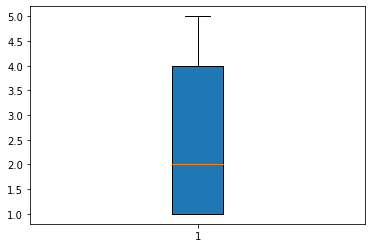

In [ ]:
plt.boxplot(histTxns.groupby('card_id').category_2.nunique(), patch_artist=True);

There are 5 different categories and the card_ids have number of different category_2 values ranging from 1-5. Therefore we introduce 5 features for the proportion of transactions belonging to each category.



In [ ]:
# new_features = proportion_feature_generator(histTxns, 'category_2', new_features, 'histCategory2Prop')
# new_features = reduce_mem_usage(new_features)
# gc.collect()

In [ ]:
# null_hist_categorical_encoders['category_2'].categories_

In [ ]:
# new_features.rename(columns={'histCategory2Prop_0.0':'histCategory2Prop_1',
#                              'histCategory2Prop_1.0':'histCategory2Prop_2',
#                              'histCategory2Prop_2.0':'histCategory2Prop_3',
#                              'histCategory2Prop_3.0':'histCategory2Prop_4',
#                              'histCategory2Prop_4.0':'histCategory2Prop_5'}, inplace=True)

#### newTxns

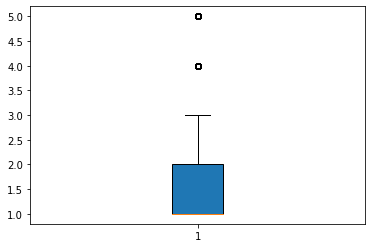

In [ ]:
plt.boxplot(newTxns.groupby('card_id').category_2.nunique(), patch_artist=True);

In [ ]:
new_features = proportion_feature_generator(newTxns, 'category_2', new_features, 'newCategory2Prop')
new_features = reduce_mem_usage(new_features)
gc.collect()

Mem. usage decreased to 62.40 Mb (13.0% reduction)


9947

In [ ]:
new_features.rename(columns={'newCategory2Prop_0.0':'newCategory2Prop_1',
                             'newCategory2Prop_1.0':'newCategory2Prop_2',
                             'newCategory2Prop_2.0':'newCategory2Prop_3',
                             'newCategory2Prop_3.0':'newCategory2Prop_4',
                             'newCategory2Prop_4.0':'newCategory2Prop_5'}, inplace=True)

In [ ]:
new_features.fillna(
    value = {
        'newCategory2Prop_1': 0.0,
        'newCategory2Prop_2': 0.0,
        'newCategory2Prop_3': 0.0,
        'newCategory2Prop_4': 0.0,
        'newCategory2Prop_5': 0.0
    },
    inplace = True
)

### category_3

#### newTxns

In [ ]:
new_features = proportion_feature_generator(newTxns, 'category_3', new_features, 'newCategory3Prop')
new_features = reduce_mem_usage(new_features)
gc.collect()

Mem. usage decreased to 64.27 Mb (8.0% reduction)


39

In [ ]:
null_hist_categorical_encoders['category_3'].categories_

[array(['A', 'B', 'C'], dtype=object)]

In [ ]:
new_features.rename(columns={'newCategory3Prop_0.0':'newCategory3Prop_A',
                             'newCategory3Prop_1.0':'newCategory3Prop_B',
                             'newCategory3Prop_2.0':'newCategory3Prop_C'}, inplace=True)

In [ ]:
new_features.fillna(
    value = {
        'newCategory3Prop_A': 0.0,
        'newCategory3Prop_B': 0.0,
        'newCategory3Prop_C': 0.0
    },
    inplace = True
)

### state_id

In [ ]:
# len(nonnull_hist_categorical_encoders['state_id'].categories_[0])

In [ ]:
# plt.boxplot(histTxns.groupby('card_id').state_id.nunique(), patch_artist=True, showfliers=False);

Given the number of unique state_ids and the box-plot above denoting the average number of state_ids per card_id, we decide to introduce features corresponding to the top 3 state_ids and their respective proportions for each card_id.

In [ ]:
# new_features.head(5)

In [ ]:
# new_features = top_n_entries_and_proportion_modified(histTxns, 3, 'state_id', 'histStateId', 'histStateIdProp', new_features, group_by='card_id')
# new_features = reduce_mem_usage(new_features)
# gc.collect()

### subsector_id

In [ ]:
# len(nonnull_hist_categorical_encoders['subsector_id'].categories_[0])

In [ ]:
# plt.boxplot(histTxns.groupby('card_id').subsector_id.nunique(), patch_artist=True, showfliers=False);

In [ ]:
# new_features = top_n_entries_and_proportion_modified(histTxns, 3, 'subsector_id', 'histSubsectorId', 'histSubsectorIdProp', new_features, group_by='card_id')
# new_features = reduce_mem_usage(new_features)
# gc.collect()

### merchant_id

#### newTxns

We want to find the number of distinct new merchant_ids visited by each card_id. Because there are no common (card_id, merchant_id) combinations in histTxns and newTxns -

In [ ]:
new_features = new_features.merge(
    newTxns[['card_id','merchant_id']].dropna().drop_duplicates().groupby('card_id')['merchant_id'].count().rename('newMerchantIDCnt'),
    how = 'left',
    on = 'card_id'
).fillna(value={'newMerchantIDCnt':0})

new_features = reduce_mem_usage(new_features)
gc.collect()

Mem. usage decreased to 52.47 Mb (3.4% reduction)


321

### merchant_category_id

#### histTxns

In [ ]:
# len(nonnull_hist_categorical_encoders['merchant_category_id'].categories_[0])

In [ ]:
# plt.boxplot(histTxns.groupby('card_id').merchant_category_id.nunique(), patch_artist=True, showfliers=False);

In [ ]:
# new_features = top_n_entries_and_proportion_modified(histTxns, 5, 'merchant_category_id', 'histMerchantCategoryID', 'histMerchantCategoryIDProp', new_features, group_by='card_id')
# new_features = reduce_mem_usage(new_features)
# gc.collect()

#### newTxns

In [ ]:
new_merchantCatId_df = newTxns[['card_id','merchant_category_id']].drop_duplicates().merge(
    histTxns[['card_id','merchant_category_id']].drop_duplicates(),
    how = 'left',
    indicator = True
)\
.query("_merge == 'left_only' ")\
.drop('_merge', axis=1)\
.reset_index(drop=True)

In [ ]:
new_features = new_features.merge(
    new_merchantCatId_df.groupby('card_id')['merchant_category_id'].count().rename('newMerchantCategoryIDCnt'),
    on = 'card_id',
    how = 'left'
).fillna(value = {'newMerchantCategoryIDCnt':0})

new_features = reduce_mem_usage(new_features)
gc.collect()

Mem. usage decreased to 53.09 Mb (3.4% reduction)


1345

We will check if the proportion of the most frequent merchant categories also changes with change in merchant_ids and by how much.

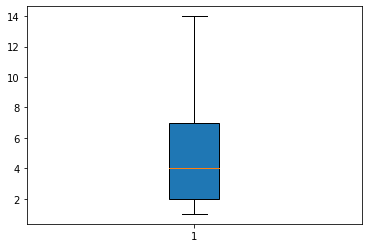

In [ ]:
plt.boxplot(
    newTxns.groupby('card_id').merchant_category_id.nunique(), 
    patch_artist=True, showfliers=False);

In [ ]:
new_features = top_n_entries_and_proportion_modified(
    df = newTxns,
    n = 5,
    col = 'merchant_category_id', 
    entry_col_name_prefix = 'newMerchantCategoryID',
    proportion_col_name_prefix = 'newMerchantCategoryIDProp',
    df_target = new_features 
)

new_features = reduce_mem_usage(new_features)
gc.collect()

Value counts time = 389.112
Mem. usage decreased to 59.30 Mb (23.9% reduction)


0

In [ ]:
new_features.fillna(
    value = {
       col_name:  (0.0 if 'newMerchantCategoryIDProp' in col_name else 9999) for col_name in new_features.columns
    },
    inplace = True
)

### Time dependant features

#### Age of card

In [ ]:
new_features = get_days_diff_and_merge(new_features, 
                        datetime.now(),
                        pd.concat([train, test], axis=0).set_index('card_id')['first_active_month'],
                        'card_age'
                        )
new_features = reduce_mem_usage(new_features)
gc.collect()

Mem. usage decreased to 49.98 Mb (3.6% reduction)


0

#### Monthly transaction count

In [ ]:
new_features = new_features.merge(
    newTxns.groupby(['card_id', newTxns.purchase_date.dt.month], sort=False)['purchase_date'].count().groupby('card_id').mean().rename('newMonthlyTxnCnt'),
    on = 'card_id',
    how = 'left'
).fillna(value={'newMonthlyTxnCnt':0})

new_features = reduce_mem_usage(new_features)
gc.collect()

Mem. usage decreased to 50.60 Mb (3.6% reduction)


15

#### Monthly purchase amounts

In [ ]:
new_features = new_features.merge(
    newTxns.groupby(['card_id', newTxns.purchase_date.dt.month], sort=False)['purchase_amount'].sum().groupby('card_id', sort=False).aggregate(
        newMonthlyAvgPurchaseAmt = 'mean',
        newMonthlySTDPurchaseAmt = 'std'
    ),
    on = 'card_id',
    how = 'left'
).fillna(value={'newMonthlyAvgPurchaseAmt':0.0, 'newMonthlySTDPurchaseAmt':0.0})

new_features = reduce_mem_usage(new_features)
gc.collect()

Mem. usage decreased to 51.85 Mb (3.5% reduction)


0

## Feature pre-processing

### Scaling features

In [ ]:
sc = StandardScaler()

In [ ]:
scaling_reqd_cols = [
              'histAuthTxnsCount', 'histUnauthTxnCount',
              'histAvgUnauthPurchaseAmt', 'histStdevUnauthPurchaseAmt',
              'histTotCityCount',
              'histAvgInstallmentNo', 'histStdevInstallmentNo',
              'histActivePeriodSpan',
              'histAvgMonthlyAuthTxnCnt', 'histStdMonthlyAuthTxnCnt',
              'histAvgMonthlyPurchaseAmt', 'histStdMonthlyPurchaseAmt',
              'histAvgMonthlyUnauthTxnCnt', 'histStdMonthlyUnauthTxnCnt',
              'histQ1TxnCnt', 'histQ2TxnCnt', 'histQ3TxnCnt', 'histQ4TxnCnt', 'histQ5TxnCnt',
              'histQ1PurchaseAmt', 'histQ2PurchaseAmt', 'histQ3PurchaseAmt', 'histQ4PurchaseAmt', 'histQ5PurchaseAmt',
              'newTxnCnt', 
              'card_age', 
              'newMonthlyTxnCnt', 'newMonthlyAvgPurchaseAmt', 'newMonthlySTDPurchaseAmt',
              'newMerchantIDCnt', 'newMerchantCategoryIDCnt'
              ]

In [ ]:
new_features.loc[:, scaling_reqd_cols] = sc.fit_transform(new_features[scaling_reqd_cols])

new_features = reduce_mem_usage(df=new_features)
gc.collect()

Mem. usage decreased to 61.47 Mb (48.4% reduction)


11

## Model fit

### Hyperparameter tuning and performance estimation

In [ ]:
new_features_train = new_features.merge(train[['card_id','target']], on='card_id')

In [ ]:
feature_cols = [x for x in new_features_train.columns if x not in ('card_id','target')]

In [ ]:
rf = RandomForestRegressor(random_state=42)

In [ ]:
param_grid = {'n_estimators': randint(10,100),
              'min_samples_split': randint(2,150),
              'max_features': uniform(0.03,1.0)
              }

In [ ]:
inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)
outer_cv = KFold(n_splits=3, shuffle=True, random_state=42)

In [ ]:
regressor = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=10, cv=inner_cv, 
                         scoring='neg_root_mean_squared_error', 
                         verbose=1,
                         n_jobs=-1,
                         random_state = 42
                         )

In [ ]:
cv_results = cross_validate(estimator=regressor,
                            X = new_features_train[feature_cols],
                            y = new_features_train['target'],
                            scoring=['neg_root_mean_squared_error','r2'],
                            cv = outer_cv,
                            return_estimator = True,
                            verbose = 10
                            )

[CV]  ................................................................
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 40.1min finished


[CV] ... , neg_root_mean_squared_error=-3.691, r2=0.063, total=41.3min
[CV]  ................................................................
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 41.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 41.2min finished


[CV] ... , neg_root_mean_squared_error=-3.717, r2=0.057, total=42.5min
[CV]  ................................................................
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 83.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 42.6min finished


[CV] ... , neg_root_mean_squared_error=-3.805, r2=0.055, total=43.9min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 127.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 127.7min finished


In [ ]:
randomized_search_results = [pd.DataFrame(est.cv_results_) for est in cv_results['estimator']]
results = reduce(lambda df1,df2: pd.concat([df1, df2]), randomized_search_results)
results.to_csv('randomized_search_run1.csv')

In [ ]:
results.sort_values(by='rank_test_score').head(6)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
9,63.538121,3.933666,1.261992,0.192899,0.120606,52,64,"{'max_features': 0.1206064345328208, 'min_samp...",-3.662601,-3.763958,-3.705771,-3.710777,0.041530,1
9,59.890854,5.450841,1.276029,0.165412,0.120606,52,64,"{'max_features': 0.1206064345328208, 'min_samp...",-3.806209,-3.752684,-3.734568,-3.764487,0.030415,1
9,62.268367,6.202222,1.320536,0.187639,0.120606,52,64,"{'max_features': 0.1206064345328208, 'min_samp...",-3.724277,-3.723223,-3.809158,-3.752219,0.040264,1
2,32.834480,0.336199,0.636317,0.010143,0.129975,89,33,"{'max_features': 0.12997491581800288, 'min_sam...",-3.811856,-3.766749,-3.742039,-3.773548,0.028905,2
2,35.463585,0.136032,0.705475,0.010742,0.129975,89,33,"{'max_features': 0.12997491581800288, 'min_sam...",-3.663979,-3.767544,-3.707198,-3.712907,0.042472,2
2,33.734524,0.665576,0.684229,0.012196,0.129975,89,33,"{'max_features': 0.12997491581800288, 'min_sam...",-3.724198,-3.730260,-3.813594,-3.756018,0.040788,2


### Permutation feature importance

After an initial run of hyperparameter tuning a base model is decided upon to check the feature importance. It will be verified if removing the least important features improves scores.

In [ ]:
# Random-forest regressor is the base model with parameters
# n_estimators = 64
# min_samples_split = 52
# max_features = 0.120606



X_train, X_test, y_train, y_test = train_test_split(new_features_train[feature_cols],
                                                    new_features_train['target'],
                                                    test_size = 0.3,
                                                    random_state = 42)

rf = RandomForestRegressor(random_state=42,
                           n_estimators = 64,
                           min_samples_split = 52,
                           max_features = 0.120606,
                           n_jobs = -1).fit(X_train, y_train)

print(f'Base score: {mean_squared_error(y_pred=rf.predict(X_test), y_true=y_test, squared=False)}')

Base score: 3.6924899009061973


In [ ]:
perm_imp = permutation_importance(rf, X_test, y_test, scoring='neg_root_mean_squared_error', n_repeats=20, n_jobs=-1, random_state=42)

In [ ]:
perm_imp.importances_mean.argsort()[::-1]

array([34, 69, 39, 15, 94, 31, 36,  1, 23, 68, 72, 70,  0, 37, 74, 79, 73,
       21, 78, 38,  2, 16, 71, 33, 24, 32, 17, 35, 28, 67, 30, 22,  3, 42,
       46, 77, 26, 20, 18, 52, 83, 75, 58, 40, 29, 82, 25,  5, 48, 54, 81,
       56,  7, 76, 66, 19,  9, 92, 27, 64,  4, 51, 11, 85, 59, 53, 91, 80,
       60, 49, 57, 10,  6, 55, 43, 14, 84, 93, 47, 86, 12, 63,  8, 61, 89,
       44, 90, 50, 13, 87, 88, 45, 62, 41, 65])

In [ ]:
feature_importance_table = pd.DataFrame()
feature_importance_table['feature_names'] = X_test.columns[perm_imp.importances_mean.argsort()[::-1]]
feature_importance_table['importance_means'] = perm_imp.importances_mean[perm_imp.importances_mean.argsort()[::-1]]
feature_importance_table['importance_std'] = perm_imp.importances_std[perm_imp.importances_mean.argsort()[::-1]]

In [ ]:
num_of_features_dict = {}
for x in np.random.randint(low=1, high=89, size=20):

  important_features_run1 = feature_importance_table.head(x)['feature_names'].to_numpy()

  rf = RandomForestRegressor(random_state=42,
                            n_estimators = 64,
                            min_samples_split = 52,
                            max_features = 0.120606,
                            n_jobs = -1).fit(X_train[important_features_run1], y_train)

  # print(f'Base score: {mean_squared_error(y_pred=rf.predict(X_test[important_features_run1]), y_true=y_test, squared=False)}')

  num_of_features_dict[x] = mean_squared_error(y_pred=rf.predict(X_test[important_features_run1]), y_true=y_test, squared=False)

min_score = min(num_of_features_dict.values())
best_no_of_features = [key for key in num_of_features_dict if num_of_features_dict[key]==min_score]

In [ ]:
best_no_of_features

[26]

In [ ]:
most_important_features = feature_importance_table.head(26)['feature_names'].to_numpy()

### Hyperparameter tuning post permutation importance

In [ ]:
# Block for randomized grid search using random forest regressor
# nested cv for test set performance estimation
rf = RandomForestRegressor(random_state=42)

param_grid = {'n_estimators': randint(40,80),
              'min_samples_split': randint(20,80),
              'max_features': uniform(0.1,0.75)
              }

inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

regressor = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=10, cv=inner_cv, 
                         scoring='neg_root_mean_squared_error', 
                         verbose=1,
                         n_jobs=-1,
                         )

cv_results = cross_validate(estimator=regressor,
                            X = new_features_train[most_important_features],
                            y = new_features_train['target'],
                            scoring=['neg_root_mean_squared_error','r2'],
                            cv = outer_cv,
                            return_estimator = True,
                            verbose = 10
                            )

[CV]  ................................................................
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 28.1min finished


[CV] ... , neg_root_mean_squared_error=-3.655, r2=0.057, total=29.5min
[CV]  ................................................................
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 29.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 20.8min finished


[CV] ... , neg_root_mean_squared_error=-3.755, r2=0.071, total=21.7min
[CV]  ................................................................
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 51.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 23.0min finished


[CV] ... , neg_root_mean_squared_error=-3.714, r2=0.065, total=23.6min
[CV]  ................................................................
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 74.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 27.5min finished


[CV] ... , neg_root_mean_squared_error=-3.743, r2=0.050, total=28.4min
[CV]  ................................................................
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 103.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 28.5min finished


[CV] ... , neg_root_mean_squared_error=-3.791, r2=0.060, total=29.1min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 132.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 132.3min finished


In [ ]:
randomized_search_results_2 = [pd.DataFrame(est.cv_results_) for est in cv_results['estimator']]
results_2 = reduce(lambda df1,df2: pd.concat([df1, df2]), randomized_search_results_2)
results_2.to_csv('randomized_search_run2.csv')

In [ ]:
results_2[results_2.rank_test_score == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
1,78.668387,0.481345,1.217696,0.020773,0.373834,66,68,"{'max_features': 0.3738341495432007, 'min_samp...",-3.763138,-3.759884,-3.728812,-3.750611,0.015472,1
2,49.964921,0.302329,1.207912,0.008157,0.256384,61,67,"{'max_features': 0.2563842585276148, 'min_samp...",-3.758239,-3.648364,-3.769161,-3.725254,0.054552,1
0,33.949053,0.373637,0.947111,0.028840,0.216518,72,58,"{'max_features': 0.21651826361257753, 'min_sam...",-3.719240,-3.674124,-3.805132,-3.732832,0.054340,1
4,43.908508,0.315904,1.112044,0.020875,0.244857,38,58,"{'max_features': 0.2448567245464956, 'min_samp...",-3.716940,-3.681936,-3.824484,-3.741120,0.060655,1
8,30.831943,0.189189,0.890722,0.023893,0.212713,55,48,"{'max_features': 0.21271333525625732, 'min_sam...",-3.739629,-3.652264,-3.772801,-3.721565,0.050840,1


In [ ]:
results_2[results_2.rank_test_score == 1].agg(func=np.mean)

mean_fit_time              47.464562
std_fit_time                0.332481
mean_score_time             1.075097
std_score_time              0.020507
param_max_features          0.260861
param_min_samples_split    58.400000
param_n_estimators         59.800000
split0_test_score          -3.739437
split1_test_score          -3.683314
split2_test_score          -3.780078
mean_test_score            -3.734277
std_test_score              0.047172
rank_test_score             1.000000
dtype: float64

## Temporary blocks

In [ ]:
# new_features.to_csv('new_features_01102021_03_54.csv', index=False)

In [ ]:
new_features_train = new_features.merge(train[['card_id','target']], on='card_id')

In [ ]:
feature_cols = [x for x in new_features_train.columns if x not in ('card_id','target')]

In [ ]:
inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)
outer_cv = KFold(n_splits=4, shuffle=True, random_state=42)

In [ ]:
rf = RandomForestRegressor(random_state=42)

In [ ]:
param_grid = {'n_estimators': [10, 50],
              'min_samples_split': [10, 100],
              'max_features': [0.1, 0.5]}

In [ ]:
regressor = GridSearchCV(estimator=rf, param_grid=param_grid, cv=inner_cv, 
                         scoring='neg_root_mean_squared_error', 
                         verbose=7,
                         n_jobs=-1
                         )

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(new_features_train[feature_cols],
                                                    new_features_train['target'],
                                                    test_size = 0.3,
                                                    random_state = 42)

In [ ]:
# cv_results = cross_validate(estimator=regressor,
#                             X = new_features_train[feature_cols],
#                             y = new_features_train['target'],
#                             scoring=['neg_root_mean_squared_error','r2'],
#                             cv = outer_cv,
#                             return_estimator = True,
#                             verbose = 4
#                             )

In [ ]:
regressor.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 19.1min finished


GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose

In [ ]:
pd.DataFrame(regressor.cv_results_).to_csv('grid_search_1_test_3_691.csv', index=False)

In [ ]:
regressor.score(X_test, y_test)

-3.6914373922927317

In [ ]:
rf = RandomForestRegressor(random_state=42, max_features=0.1, verbose=2)

In [ ]:
param_grid_2 = {'n_estimators': [50, 75, 100],
              'min_samples_split': [20, 60, 100]}

In [ ]:
regressor2 = GridSearchCV(estimator=rf, param_grid=param_grid_2, cv=inner_cv, 
                         scoring='neg_root_mean_squared_error', 
                         verbose=3,
                         n_jobs=-1
                         )

In [ ]:
regressor2.fit(X_train, y_train)

In [ ]:
pd.DataFrame(regressor2.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,50.102673,0.079331,1.348845,0.007483,20,50,"{'min_samples_split': 20, 'n_estimators': 50}",-3.746382,-3.828751,-3.745015,-3.773382,0.039155,9
1,75.054831,0.215345,1.994313,0.015168,20,75,"{'min_samples_split': 20, 'n_estimators': 75}",-3.741628,-3.819369,-3.736971,-3.765989,0.037793,8
2,101.096685,0.491589,2.694486,0.016525,20,100,"{'min_samples_split': 20, 'n_estimators': 100}",-3.738336,-3.814844,-3.734771,-3.762650,0.036935,6
3,44.308520,0.175031,1.172060,0.008367,60,50,"{'min_samples_split': 60, 'n_estimators': 50}",-3.740070,-3.811979,-3.736291,-3.762780,0.034823,7
4,65.807988,0.112114,1.689348,0.039349,60,75,"{'min_samples_split': 60, 'n_estimators': 75}",-3.733617,-3.810776,-3.733795,-3.759396,0.036331,4
5,87.697334,0.264262,2.271882,0.043184,60,100,"{'min_samples_split': 60, 'n_estimators': 100}",-3.733422,-3.808130,-3.731486,-3.757679,0.035683,2
6,40.873047,0.039518,1.074902,0.004148,100,50,"{'min_samples_split': 100, 'n_estimators': 50}",-3.736287,-3.815146,-3.735208,-3.762214,0.037432,5
7,61.267514,0.242280,1.593149,0.009854,100,75,"{'min_samples_split': 100, 'n_estimators': 75}",-3.730248,-3.812198,-3.732140,-3.758195,0.038193,3
8,78.419926,4.881121,1.904553,0.264015,100,100,"{'min_samples_split': 100, 'n_estimators': 100}",-3.728652,-3.809745,-3.730146,-3.756181,0.037881,1


In [ ]:
regressor2.score(X_test, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.9s finished


-3.6872325616079693

In [ ]:
param_grid_3 = {'min_samples_split': randint(200,400)}

In [ ]:
rf = RandomForestRegressor(random_state=42, max_features=0.1, n_estimators=100, verbose=1)

In [ ]:
regressor3 = RandomizedSearchCV(estimator=rf, param_distributions=param_grid_3, n_iter=10, cv=inner_cv, 
                         scoring='neg_root_mean_squared_error', 
                         verbose=3,
                         n_jobs=-1
                         )

In [ ]:
regressor3.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.3min finished


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
                   error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features=0.1,
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                    

In [ ]:
pd.DataFrame(regressor3.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,64.163149,0.236754,1.494110,0.021608,386,{'min_samples_split': 386},-3.733880,-3.812780,-3.734129,-3.760263,0.037135,10
1,65.017420,0.073118,1.537872,0.003923,368,{'min_samples_split': 368},-3.733210,-3.812068,-3.734012,-3.759763,0.036986,6
2,70.534903,0.249769,1.685256,0.027595,247,{'min_samples_split': 247},-3.728990,-3.811120,-3.730169,-3.756760,0.038441,1
3,69.316227,0.177451,1.619207,0.011331,267,{'min_samples_split': 267},-3.730419,-3.811062,-3.730926,-3.757469,0.037897,4
4,64.581584,0.119427,1.457651,0.005407,397,{'min_samples_split': 397},-3.734061,-3.811470,-3.733983,-3.759838,0.036509,8
5,64.750549,0.437569,1.514983,0.011333,384,{'min_samples_split': 384},-3.733774,-3.813239,-3.733023,-3.760012,0.037638,9
6,64.248586,0.201700,1.499857,0.014153,390,{'min_samples_split': 390},-3.733250,-3.813379,-3.731636,-3.759421,0.038159,5
7,72.754632,0.110083,1.746888,0.023665,209,{'min_samples_split': 209},-3.728775,-3.811714,-3.730773,-3.757087,0.038636,3
8,70.811274,0.431427,1.704079,0.016762,239,{'min_samples_split': 239},-3.729289,-3.811064,-3.729978,-3.756777,0.038388,2
9,65.084155,0.680013,1.379958,0.229447,350,{'min_samples_split': 350},-3.731970,-3.812888,-3.734580,-3.759813,0.037545,7


In [ ]:
regressor3.score(X_test, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.6s finished


-3.6912524680416885